In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [25]:
mackerel=pd.read_csv('./data/merge/mackerel_total.csv')

# '%Y-%m' 형식으로 변환
mackerel['date'] = pd.to_datetime(mackerel['date'], format='%Y-%m-%d')

# 'date' 열을 인덱스로 설정
mackerel.set_index('date', inplace=True)

mackerel=mackerel[['수입','생산량','가격 (원)']]
mackerel.info()
mackerel

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 2013-12-01 to 2023-12-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   수입      121 non-null    int64  
 1   생산량     121 non-null    int64  
 2   가격 (원)  121 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 3.8 KB


,수입,생산량,가격 (원)
date,,,
2013-12-01,5386,21006,3225.0
2014-01-01,3476,5663,3422.0
2014-02-01,1101,3565,4073.0
2014-03-01,2011,2620,3891.0
2014-04-01,2454,1525,4259.0
...,...,...,...
2023-08-01,2876,5698,2932.0
2023-09-01,349,9903,2875.0
2023-10-01,193,9163,2489.0


In [28]:
seq_length=3 # 3~7사이 값 설정
train_size = int(len(mackerel)*0.9)
train_set=mackerel[0:train_size]
test_set=mackerel[train_size-seq_length:]
print(train_set.shape,test_set.shape)


(108, 3) (16, 3)


In [29]:
train_set.head()

,수입,생산량,가격 (원)
date,,,
2013-12-01,5386,21006,3225.0
2014-01-01,3476,5663,3422.0
2014-02-01,1101,3565,4073.0
2014-03-01,2011,2620,3891.0
2014-04-01,2454,1525,4259.0


In [30]:
#input scale
scaler_x=MinMaxScaler()
scaler_x.fit(train_set.iloc[:, :-1])

train_set.iloc[:, :-1]=scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1]=scaler_x.transform(test_set.iloc[:, :-1])

# output scale
scaler_y=MinMaxScaler()
scaler_y.fit(train_set.iloc[:,[-1]])
train_set.iloc[:, -1]=scaler_y.transform(train_set.iloc[:,[-1]])
test_set.iloc[:, -1]=scaler_y.transform(test_set.iloc[:,[-1]])

In [31]:
test_set[:]

,수입,생산량,가격 (원)
date,,,
2022-09-01,0.170802,0.167027,-0.513869
2022-10-01,0.037966,0.162313,-0.513859
2022-11-01,0.027795,0.746054,-0.513851
2022-12-01,0.819290,0.504547,0.325399
2023-01-01,0.730820,0.569143,0.356235
2023-02-01,0.359930,0.044494,0.387071
2023-03-01,0.659097,0.272346,0.417906
2023-04-01,0.688558,0.206137,0.440222
2023-05-01,0.327488,0.028436,0.462537


In [32]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
import numpy as np

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(125)
if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [35]:
def build_dataset(time_series, seq_length):
    dataX=[]
    dataY=[]
    for i in range(0, len(time_series)-seq_length):
        x_=time_series[i:i+seq_length, :]
        y_=time_series[i+seq_length,[2]]
        dataX.append(x_)
        dataY.append(y_)
    return np.array(dataX), np.array(dataY)

In [36]:
trainX, trainY=build_dataset(np.array(train_set), seq_length)
testX, testY=build_dataset(np.array(test_set),seq_length)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(105, 3, 3) (105, 1)
(13, 3, 3) (13, 1)


In [37]:
trainX_tensor=torch.FloatTensor(trainX)
trainY_tensor=torch.FloatTensor(trainY)
testX_tensor=torch.FloatTensor(testX)
testY_tensor=torch.FloatTensor(testY)

print(trainX_tensor.size(), trainY_tensor.size())
print(testX_tensor.size(), testY_tensor.size())

torch.Size([105, 3, 3]) torch.Size([105, 1])
torch.Size([13, 3, 3]) torch.Size([13, 1])


In [38]:
train_dataset=TensorDataset(trainX_tensor, trainY_tensor)
train_loader=DataLoader(train_dataset, shuffle=True,
                        drop_last=True)

In [39]:
# 수정 필요

data_dim=3
hidden_dim=6
output_dim=1
learning_late=0.01
epochs=1000

In [40]:
class Net(nn.Module):
  def __init__(self, input_dim, hidden_dim, seq_length, output_dim, layers):
    super(Net, self).__init__()
    self.hidden_dim=hidden_dim
    self.seq_length=seq_length
    self.output_dim=output_dim
    self.layers=layers

    self.lstm=nn.LSTM(input_dim, 
                      hidden_dim, 
                      num_layers=layers,
                      batch_first=True)
    self.fc=nn.Linear(hidden_dim, output_dim, bias=True)

  def reset_hidden_state(self):
    self.hidden=(
      torch.zeros(self.layers, self.seq_length, self.hidden_dim),
      torch.zeros(self.layers, self.seq_length, self.hidden_dim)
    )
  def forward(self, x):
    x, _status=self.lstm(x)
    x=self.fc(x[:, -1])
    return x

In [41]:
def train_model(model, train_df, epochs=None, lr=None, verbos=10, patience=10):
  criterion=nn.MSELoss().to(device)
  optimizer=optim.Adam(model.parameters(), lr=learning_late)
  n_epochs=epochs

  train_hist=np.zeros(n_epochs)
  for epoch in range(n_epochs):
    avg_cost=0
    total_batch=len(train_df)

    for batch_idxm, sample in enumerate(train_df):
      x_train, y_train=sample
      model.reset_hidden_state()
      output=model(x_train)
      loss=criterion(output, y_train)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      avg_cost+=loss/total_batch
    
    train_hist[epoch]=avg_cost

    if epoch % verbos==0:
      print('Epoch:{}, train_loss:{}'.format(epoch, avg_cost.item()))

    if(epoch % patience==0) & (epoch!=0):
      if train_hist[epoch-patience] < train_hist[epoch]:
        print("Early Stopping")
        break
  return model.eval(), train_hist

# best loss / model 추가

In [42]:
net=Net(data_dim, hidden_dim, seq_length, output_dim, 1)
model, train_hist=train_model(net, train_loader, epochs=epochs,
                              lr=learning_late, verbos=20, patience=100)

Epoch:0, train_loss:0.05679186061024666
Epoch:20, train_loss:0.021564360707998276
Epoch:40, train_loss:0.016412053257226944
Epoch:60, train_loss:0.013076665811240673
Epoch:80, train_loss:0.006196561269462109
Epoch:100, train_loss:0.006873837672173977
Epoch:120, train_loss:0.005895999725908041
Epoch:140, train_loss:0.003526827087625861
Epoch:160, train_loss:0.0033532751258462667
Epoch:180, train_loss:0.0035244165919721127
Epoch:200, train_loss:0.0024922762531787157
Epoch:220, train_loss:0.002757737413048744
Epoch:240, train_loss:0.0020941223483532667
Epoch:260, train_loss:0.0034610535949468613
Epoch:280, train_loss:0.0018239663913846016
Epoch:300, train_loss:0.0021367380395531654
Epoch:320, train_loss:0.006562721915543079
Epoch:340, train_loss:0.002103008795529604
Epoch:360, train_loss:0.0012410137569531798
Epoch:380, train_loss:0.0008527680183760822
Epoch:400, train_loss:0.0029907585121691227
Early Stopping


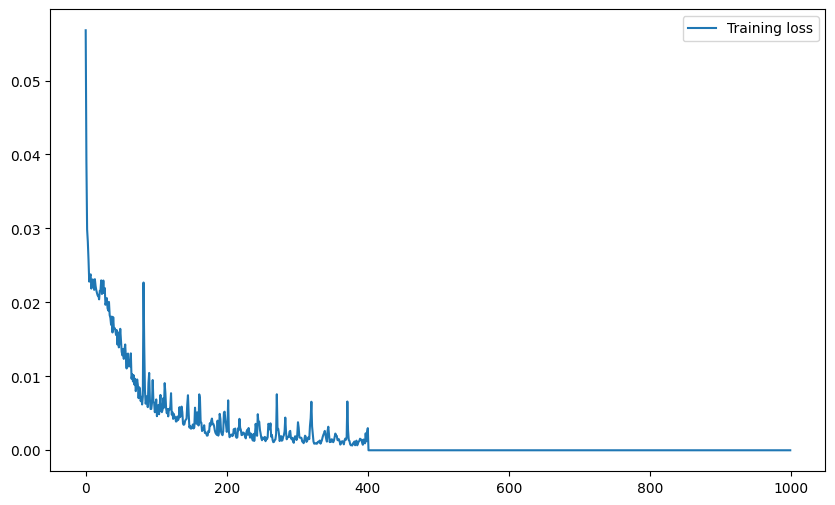

In [43]:
fig=plt.figure(figsize=(10, 6))
plt.plot(train_hist, label='Training loss')
plt.legend()
plt.show()

In [44]:
with torch.no_grad():
    pred=[]
    for pr in range(len(testX_tensor)):
        model.reset_hidden_state()
        predicted=model(torch.unsqueeze(testX_tensor[pr],0))
        predicted=torch.flatten(predicted).item()
        pred.append(predicted)

    pred_inverse=scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse=scaler_y.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))


print('MAe SCORE:', MAE(pred_inverse, testY_inverse))

MAe SCORE: 549.1859865108362


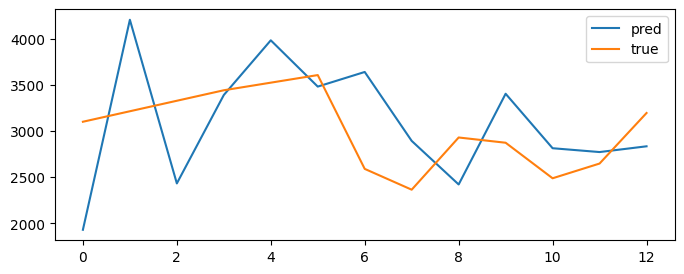

In [45]:
fig=plt.figure(figsize=(8,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label='pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label='true')
plt.legend()
plt.show()